# Support Vector Machines

In [1]:
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
from utils import (
    generateRings,
    loadMNIST,
    plot_multiple_images,
    plotClassification,
    plotRegression,
    scatter_label_points,
)

%load_ext autoreload
%autoreload 2

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

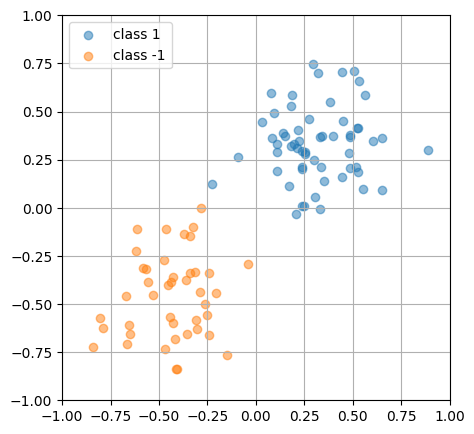

In [2]:
file = open("datasets/classification_datasets", "rb")
datasets = pkl.load(file)
file.close()
dataset = datasets["dataset_1"]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plotClassification(dataset["train"]["x"], dataset["train"]["y"], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [3]:
class RBF:
    def __init__(self, sigma=1.0):
        self.sigma = sigma  ## the variance of the kernel

    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        G = np.exp(
            -np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=-1) ** 2
            / (2 * self.sigma * 2)
        )
        return G  ## Matrix of shape NxM


class Linear:
    def __init__(self):
        pass

    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        G = X @ Y.T
        return G  ## Matrix of shape NxM



### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [4]:
class KernelSVC:
    def __init__(self, C, kernel, epsilon=1e-3):
        self.type = "non-linear"
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None

    def fit(self, X, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        kernel_values = self.kernel(X, X)
        # Lagrange dual problem
        def loss(alpha):
            alpha_y = alpha * y
            norm_term = alpha_y.T @ kernel_values @ alpha_y
            alpha_term = np.sum(alpha)
            return (
                -alpha_term + 0.5 * norm_term
            )  #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            alpha_y = alpha * y
            return (alpha_y[None, :] * kernel_values).sum(
                axis=1
            ) * y - 1  # '''----------------partial derivative of the dual loss wrt alpha -----------------'''

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: -(
            alpha * y
        ).sum()  # '''----------------function defining the equality constraint------------------'''
        jac_eq = (
            lambda alpha: -y
        )  #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = (
            lambda alpha: self.C - alpha
        )  # '''---------------function defining the inequality constraint-------------------'''
        jac_ineq = lambda alpha: -np.eye(
            len(alpha)
        )  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        fun_ineq2 = (
            lambda alpha: alpha
        )  # '''---------------function defining the positivity constraint-------------------'''
        jac_ineq2 = lambda alpha: np.eye(
            len(alpha)
        )  # '''---------------jacobian wrt alpha of the  positivity constraint-------------------'''

        constraints = (
            {"type": "eq", "fun": fun_eq, "jac": jac_eq},
            {"type": "ineq", "fun": fun_ineq, "jac": jac_ineq},
            {"type": "ineq", "fun": fun_ineq2, "jac": jac_ineq2},
        )
        optRes = optimize.minimize(
            fun=lambda alpha: loss(alpha),
            x0=np.ones(N),
            method="SLSQP",
            jac=lambda alpha: grad_loss(alpha),
            constraints=constraints,
        )
        self.alpha = optRes.x

        ## Assign the required attributes
        alpha_y = self.alpha * y
        mask = self.alpha > self.epsilon
        self.alpha_y_support = (alpha_y)[mask]
        self.support = X[
            mask, :
        ]  #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        self.b = -np.mean(
            self.separating_function(self.support)
        )  #''' -----------------offset of the classifier------------------ '''
        self.norm_f = (
            alpha_y.T @ kernel_values @ alpha_y
        )  # '''------------------------RKHS norm of the function f ------------------------------'''

    ### Implementation of the separting function $f$
    def separating_function(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return (self.alpha_y_support[None, :] * self.kernel(x, self.support)).sum(
            axis=1
        )

    def predict(self, X):
        """Predict y values in {-1, 1}"""
        d = self.separating_function(X)
        return 2 * (d + self.b > 0) - 1


### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 45


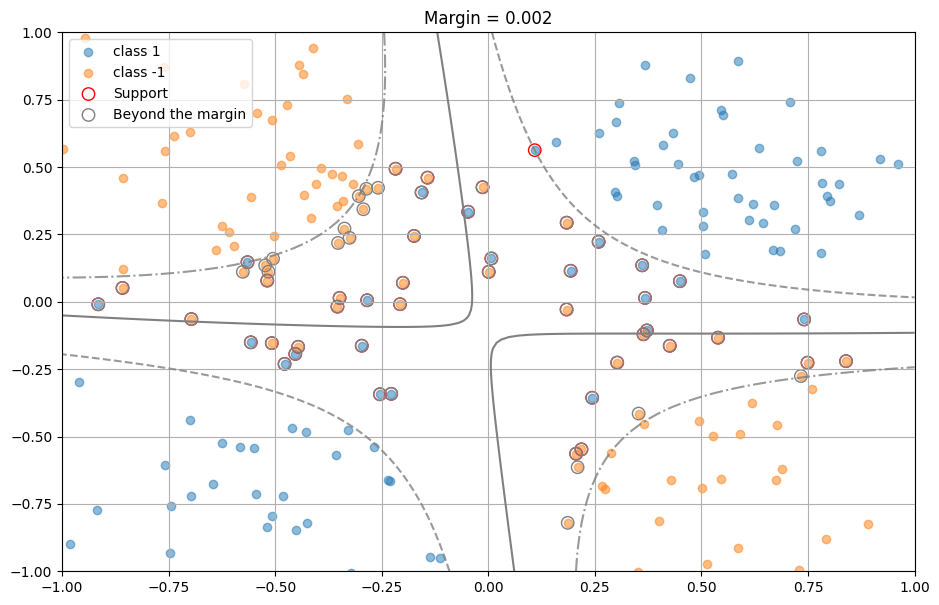

In [5]:
sigma = 1.5
C = 100.0
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets[f"dataset_3"]["train"]
model.fit(train_dataset["x"], train_dataset["y"])
plotClassification(train_dataset["x"], train_dataset["y"], model, label="Training")


# Kernel Regression

## Loading the data

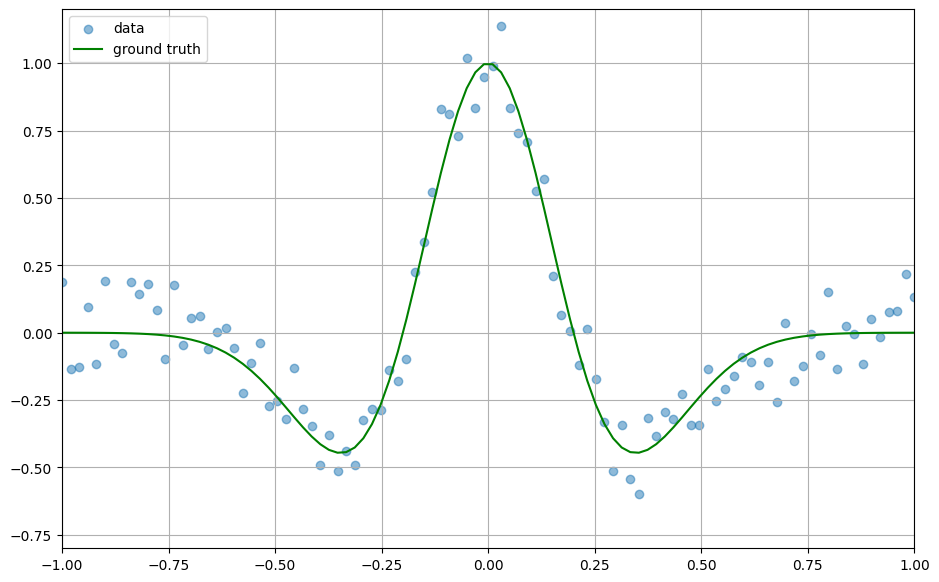

In [6]:
file = open("datasets/regression_datasets", "rb")
datasets = pkl.load(file)
file.close()
train_set = datasets["dataset_1"]["train"]
train_set = datasets["dataset_1"]["test"]
plotRegression(train_set["x"], train_set["y"], Y_clean=train_set["y_clean"])


## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [7]:
class KernelRR:
    def __init__(self, kernel, lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.alpha = None
        self.b = None
        self.support = None
        self.type = "ridge"

    def fit(self, X, y):
        self.support = X
        kernel = self.kernel(X, X)
        n = len(y)
        self.alpha = np.linalg.solve(kernel + self.lmbda * n * np.eye(n), y)
        self.b = -np.mean(self.regression_function(X))

    ### Implementation of the separting function $f$
    def regression_function(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return (self.alpha[None, :] * self.kernel(x, self.support)).sum(
            axis=1
        )

    def predict(self, X):
        """Predict y values in {-1, 1}"""
        return self.regression_function(X) + self.b


class MultivariateKernelRR:
    def __init__(self, kernel, lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type = "ridge"

    def fit(self, X, y):
        self.support = X
        kernel = self.kernel(X, X)
        n = len(y)
        self.alpha = np.linalg.solve(kernel + self.lmbda * n * np.eye(n), y)
        self.b = -np.mean(self.regression_function(X))

    ### Implementation of the separting function $f$
    def regression_function(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return (self.alpha[None, :] * self.kernel(x, self.support)).sum(
            axis=1
        )

    def predict(self, X):
        """Predict y values in {-1, 1}"""
        return self.regression_function(X) + np.expand_dims(self.b, axis=0)

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

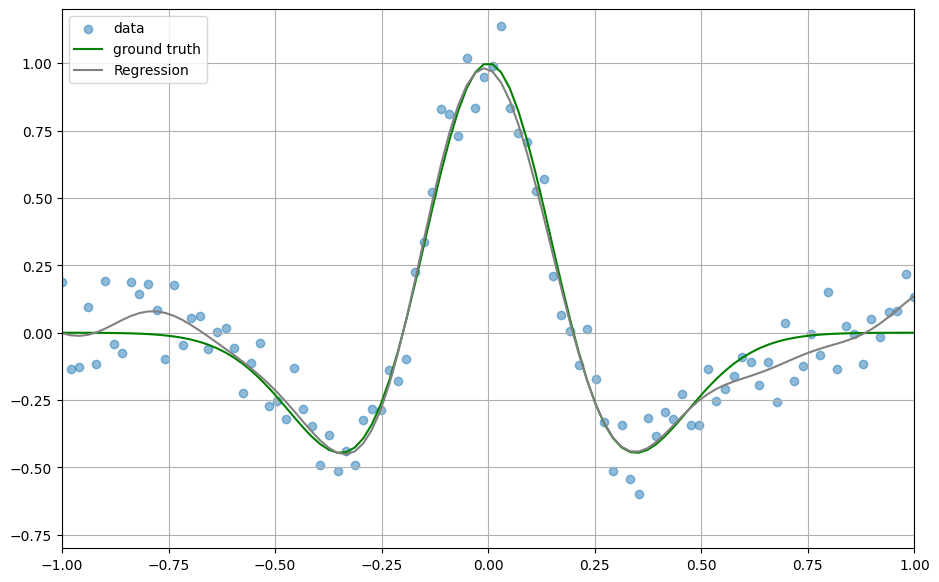

In [8]:
sigma = 0.01
lmbda = 0.001
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)

model.fit(train_set["x"].reshape(-1, 1), train_set["y"])
plotRegression(
    train_set["x"],
    train_set["y"],
    Y_clean=train_set["y_clean"],
    model=model,
    label="Train",
)


# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [17]:
class KernelPCA:
    def __init__(self, kernel, r=2):
        self.kernel = kernel  # <---
        self.alpha = None  # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None  # Vector of size d representing the top d eingenvalues
        self.support = None  # Data points where the features are evaluated
        self.r = r  ## Number of principal components

    def compute_PCA(self, X):
        # assigns the vectors
        n = len(X)
        G = self.kernel(X, X)
        G = (
            (np.eye(n) - 1 / n * np.ones((n, n)))
            @ G
            @ (np.eye(n) - 1 / n * np.ones((n, n)))
        )
        eigenvalues, eigenvectors = np.linalg.eigh(G / n)
        indices = np.argsort(eigenvalues)
        self.lmbda = eigenvalues[indices][: self.r]
        self.alpha = eigenvectors[indices][: self.r]
        self.support = X

        # constraints = ({})
        # Maximize by minimizing the opposite

    def transform(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        G = self.kernel(x, self.support)
        return G @ self.alpha.T


### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

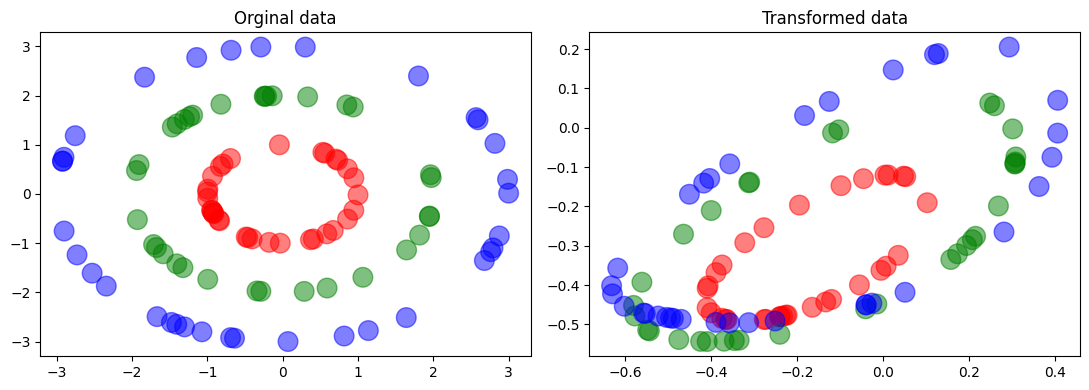

In [18]:
file = open("datasets/pca_datasets", "rb")
datasets = pkl.load(file)
file.close()
train_set = datasets["dataset_1"]["train"]
test_set = datasets["dataset_1"]["test"]

sigma = 4.0
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r=10)
pca.compute_PCA(train_set["x"])
pca_components = pca.transform(test_set["x"])

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
scatter_label_points(test_set["x"], test_set["y"], ax[0], title="Orginal data")
scatter_label_points(pca_components, test_set["y"], ax[1], title="Transformed data")
plt.tight_layout()
plt.savefig("KernelPCA.jpg", dpi=300)


# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

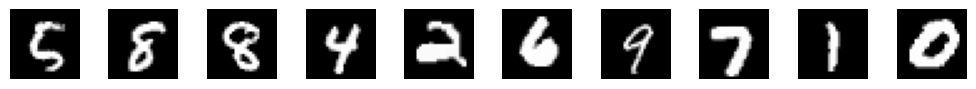

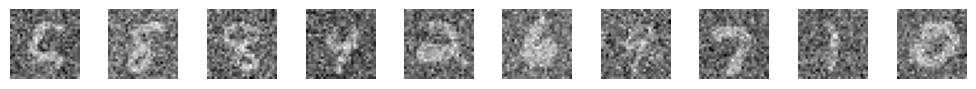

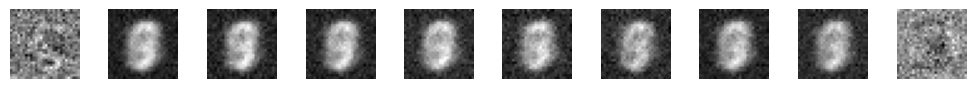

In [19]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self,train):
        n = len(train)
        self.pca.compute_PCA(train.reshape(n, -1))
        pca_components = self.pca.transform(train.reshape(n, -1))
        self.ridge_reg.fit(pca_components, train.reshape(n, -1))
        
    def denoise(self,test):
        n = len(test)
        pca_components = self.pca.transform(test.reshape(n, -1))
        prediction = self.ridge_reg.predict(pca_components)
        return prediction.reshape((n, 28, 28))

class MultivariateKernelRR:
    def __init__(self, kernel, lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type = "ridge"

    def fit(self, X, y):
        self.support = X
        kernel = self.kernel(X, X)
        n = len(y)
        self.alpha = np.linalg.solve(kernel + self.lmbda * n * np.eye(n), y)
        self.b = - np.mean(self.regression_function(X), axis=0)

    ### Implementation of the separting function $f$
    def regression_function(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        kernel = self.kernel(x, self.support)
        images = [(kernel[i, :][:, None] * self.alpha).sum(axis=0) for i in range(len(x))]
        images = np.stack(images, axis=0)
        return images

    def predict(self, X):
        """Predict y values in {-1, 1}"""
        return self.regression_function(X) + np.expand_dims(self.b, axis=0)

datasets = loadMNIST("datasets/SubsetMNIST")
clean_data = datasets["cleanMNIST"]
data = datasets["noisyMNIST"]


dim_pca = 80
lmbda = 1.0
sigma_encoder = 8.0
sigma_decoder = 5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder, kernel_decoder, dim_pca, lmbda)

denoiser.fit(data["train"][:200])
pred = denoiser.denoise(data["train"][:10])
plot_multiple_images(clean_data["train"][:10])
plot_multiple_images(data["train"][:10])
plot_multiple_images(pred)


### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

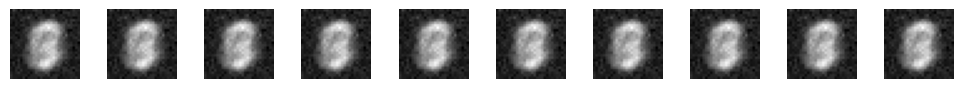

In [45]:
datasets = loadMNIST("datasets/SubsetMNIST")
clean_data = datasets["cleanMNIST"]
data = datasets["noisyMNIST"]


dim_pca = 80
lmbda = 10.0
sigma_encoder = 8.0
sigma_decoder = 0.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder, kernel_decoder, dim_pca, lmbda)

denoiser.fit(data["train"][:200])
pred = denoiser.denoise(data["test"][:10])
# plot_multiple_images(clean_data["test"][:10])
# plot_multiple_images(data["test"][:10])
plot_multiple_images(pred)
plt.tight_layout()
plt.savefig("denoised.jpg", dpi=300)